# DP0.2 Notebook 17 Galaxy Photometry
<div>
<img align="left" src="attachment:90083a24-00a4-4a6f-a1c3-b9b4c6b0de9e.png" width="300" style="padding-right: 20px;"/>
</div>
Contact author(s): Christina Williams <br>
Last verified to run: 2024-02-10 <br>
LSST Science Pipelines version: Weekly 2025_09 <br>
Container Size: medium <br>

**Description:** Explore the available measurements of galaxy photometry produced by the LSST pipelines and their applications.

**Skills:** Basic understanding of photometric measurement methods typically used to characterize galaxies.

**LSST Data Products:** objectTable

**Packages:** `lsst.afw`, `astropy`, `photutils`, `scipy.stats`

**Credit:**
This notebook benefitted from earlier exploration of simulated data and notebook development by Melissa Graham and Dan Taranu, helpful discussions with Jim Bosch, and ideas from Douglas Tucker. 

**Get Support:**
Find DP0-related documentation and resources at <a href="https://dp0.lsst.io">dp0.lsst.io</a>.
Questions are welcome as new topics in the 
<a href="https://community.lsst.org/c/support/dp0">Support - Data Preview 0 Category</a> 
of the Rubin Community Forum. 
Rubin staff will respond to all questions posted there.

# 1. Introduction

Photometry is the measurement of how much light is apparent from astronomical sources. The amount of light arriving on the telescope from the object is typically referred to as the flux density, or apparent magnitude (depending on units). Flux density is defined as the amount of energy arriving on the telescope per unit area, per unit time, per unit frequency (or wavelength) of the light.

The LSST Science Pipelines makes a variety of photometric measurements for point-like and extended sources. This notebook will teach the user about the automated photometry measurements that are measured on the deepCoadd images and appear in the Object Catalog as part of the LSST pipelines data products. The focus will be on galaxies, and thus is distinct from the demonstrations in DP0.2 Tutorial Notebooks 12a (about PSF data products) and 12b (a PSF science demo).

Please note that these explanations are specific to DP0.2: the `objectTable` contents and definitions are still subject to change for DP1. The photometry in the catalog are flux densities in units of nano-Jansky [nJy]. 1 Jy = 10^{-23} ergs/s/cm^2/Hz.


## 1.1 Types of photometry measurements in the Object Table

Schema for the object catalog for DP0.2 <a href="https://sdm-schemas.lsst.io/dp02.html">is available here</a>.

Numerous photometry measurements are produced by the LSST Pipelines. Two types of photometry are there. The first are total fluxes (see Section 1.1.1), which aim to approximate (or model) all of the light coming from objects. Measurements that approximate total flux are "Composite Model" (cModel) fluxes. The second class of fluxes are measured inside an on-sky aperture but not corrected for flux that may fall outside: thus they are apparent fluxes but do not recover the intrisic (total) flux (see Section 1.1.2). The apparent fluxes are optimized for other purposes, such as for measuring accurate light profiles or accurate colors.

### 1.1.1 Total fluxes


#### Composite Model (CModel) fluxes

Similar in nature to those measured for SDSS (information <a href="https://www.sdss3.org/dr8/algorithms/magnitudes.php#cmodel">available here</a>). 


In short, it is the linear combination of the best fit exponential (disk or D) and de Vaucouleurs (bulge or B) profiles. 

```
<f>_cModelFlux    : Flux from the final cmodel fit. Forced on <f>-band.
<f>_cModelFluxErr : Uncertainty of <f>_cModelFlux
<f>_cModel_flag   : Failure flag for <f>_cModelFlux
```

For most cases the "fixed" cModel photometry (as listed above) are preferred to that measured with more degrees of freedom labeled `<f>_free_cModelFlux`. The difference is that the fixed ones above uses a reference band (recorded as `refBand` in the schema) where the galaxy is well detected to determine the other parameters, which are then fixed when fitting for the flux in the other bands. The `_free_cModelFlux` measurement allows all parameters to be free and independent in each filter. The fixed `_cModelFlux` measurements are generally recommended for galaxy science applications where total flux measurements are needed (e.g. for intrinsic luminosity or mass).

### 1.1.2 Apparent fluxes (i.e. not corrected to the total flux)
 
#### Kron fluxes

A decent summary of Kron fluxes <a href="https://ned.ipac.caltech.edu/level5/March05/Graham/Graham2_6.html">in the NED documentation</a>. The aperture used for the fluxes is 2.5 x R1 where R1 is the luminosity weighted radius (also called "first moment"; Kron et al. 1980).

```
<f>_kronFlux      : Flux from Kron Flux algorithm. Measured on <f>-band.
<f>_kronFluxErr   : Uncertainty of <f>_kronFlux.
<f>_kronFlux_flag : Failure flag for <f>_kronFlux.
```

The Kron radius, `<f>_kronRad`, is also available. In this case of LSST pipeline output, the Kron flux is not corrected for light that is emitted outside of the Kron aperture. While in many cases it will collect the majority of light, it will not be as accurate as the cModel for science cases requiring total flux.


#### Aperture fluxes
This contains the enclosed flux inside a given aperture (they are not corrected to total fluxes using an aperture correction that accounts for the flux falling outside the aperture). Fixed aperture size refers to the aperture radius in pixels.

```
<f>_ap<pix>Flux     : Flux within <pix>-pixel aperture. Forced on <f>-band.
<f>_ap<pix>FluxErr  : Uncertainty of <f>_ap<pix>Flux.
<f>_ap<pix>FluxFlag : Failure flag for <f>_ap<pix>Flux.
```

For DP0.2, the apertures are 3, 6, 9, 12, 17, 25, 35, 50, and 70 pixels. In the column name, apertures are `03`, `06`, `09`, `12`, and so on. While aperture fluxes are not corrected for the loss outside the aperture, if the aperture size is much larger than the galaxy size then it will approximate the total flux of the galaxy. The general application of these measurements are for measuring radial profiles (see Section 4 below).

#### GaaP fluxes

These are the Gaussian-aperture-and-PSF flux that is defined in <a href="https://ui.adsabs.harvard.edu/abs/2008A%26A...482.1053K/abstract">Kuijken et al. 2008</a>. The main goal of this method is to measure accurate colors while accounting for the different spatial resolution between filters. This is sometimes achieved in other datasets by convolving all images to the largest PSF, but this process of PSF-matching is computationally very time consuming for large images, thus motivating GaaP as a faster alternative. It is not a measure of total flux in a filter. Several measurement apertures are available. 

**Aperture**

```
<f>_gaap<ap>Flux    : GaaP flux with <ap> aperture after multiplying the seeing aperture. Forced on <f>-band.
<f>_gaap<ap>FluxErr : Uncertainty of <f>_gaap<ap>Flux.
```

Where the measurement apertures are 0.5, 0.7, 1.0, 1.5, 2.5, and 3.0 arcseconds. In the column name `<ap>` appears as `0p5`, `0p7`, etc. Multiplying by the "seeing aperture" refers to convolving the PSF with a kernel so that the PSF is as if the seeing were 1.15 arcseconds. This has the effect of smearing the images of all filters consistently so that the colors are accurate.

For photometric redshifts, and other analysis where accurate colors are important, it is recommended to use the GaaP fluxes with 1.0 aperture (optimal aperture was found to not perform as well, and should not be used). 

#### PSF fluxes

Fluxes derived using the model point-spread function (PSF) of the image. Since PSF fluxes are designed for unresolved sources (not the majority of galaxies) this notebook will not explore science applications for this type of photometry. Interested users can find more information in the PSF Tutorial notebooks 12a and 12b. 

```
<f>_psfFlux      : Flux derived from linear least-squares fit of PSF model. Forced on <f>-band.
<f>_psfFluxErr   : Uncertainty of <f>_psfFlux.
<f>_psfFlux_flag : Failure flag for <f>_psfFlux.

```


## 1.2 Import packages


`numpy` is a fundamental package for scientific computing with arrays in Python
(<a href="https://numpy.org">numpy.org</a>).

`matplotlib` is a comprehensive library for creating static, animated, and
interactive visualizations in Python 
(<a href="https://matplotlib.org/">matplotlib.org</a>; 
<a href="https://matplotlib.org/stable/gallery/index.html">matplotlib gallery</a>).

`scipy.stats` contains statistical packages, this notebook will use binned_statistic to calculate running medians.

From the `lsst` package, modules for accessing the TAP service, and image display functions from `afw` are imported (<a href="https://pipelines.lsst.io/">pipelines.lsst.io</a>). Also import some geometric functions to help plot photometric apertures.

From the `pyvo` package, import some functions that will enable using the image cutout tool.

Finally, from `astropy` and `photutils` import packages to enable plotting images and drawing shapes on images with WCS information.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import binned_statistic

import lsst.geom as geom
import lsst.resources
import lsst.afw.display as afwDisplay
from lsst.afw.image import ExposureF
from lsst.rsp import get_tap_service
from lsst.afw.fits import MemFileManager
import lsst.afw.geom.ellipses as ellipses

from pyvo.dal.adhoc import DatalinkResults, SodaQuery
import uuid

from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.wcs import WCS
from photutils.aperture import SkyCircularAperture, SkyEllipticalAperture


## 1.3 Define functions and parameters


### 1.3.1 Define some plotting defaults

In [2]:
afwDisplay.setDefaultBackend('matplotlib')

plt.style.use('tableau-colorblind10')


### 1.3.2 Initialize the TAP service

In [3]:
service = get_tap_service("tap")

### 1.3.3 Define a shortcut function to generate an image cutout using the cutout tool
Further information about the cutout tool can be found in DP0.2 tutorial notebook 13a that demonstrates the Rubin image cutout service. 

In [4]:
def make_image_cutout(tap_service, ra, dec, cutout_size=0.01):
    """
    Wrapper function to generate a cutout using the cutout tool

    Parameters
    ----------
    tap_service : an instance of the TAP service
    ra, dec : 'float'
        the ra and dec of the cutout center
    cutout_size : 'float', optional
        edge length in degrees of the cutout

    Returns
    -------
    mem : 'object'
        An lsst.afw.fits._fits.MemFileManager object containing the
        cutout image bytes returned by the cutout tool
    """

    spherePoint = geom.SpherePoint(ra*geom.degrees, dec*geom.degrees)
    coord = SkyCoord(ra=ra*u.degree, dec=dec*u.degree, frame='icrs')

    band = 'i'

    query = "SELECT access_format, access_url, dataproduct_subtype, " + \
            "lsst_patch, lsst_tract, lsst_band, s_ra, s_dec " + \
            "FROM ivoa.ObsCore WHERE dataproduct_type = 'image' " + \
            "AND obs_collection = 'LSST.DP02' " + \
            "AND dataproduct_subtype = 'lsst.deepCoadd_calexp' " + \
            "AND lsst_band = " + "'" + str(band) + "' " + \
            "AND CONTAINS(POINT('ICRS', " + str(coord.ra.value) + \
            ", " + str(coord.dec.value) + "), " + \
            "s_region) = 1"

    results = tap_service.search(query)

    dataLinkUrl = results[0].getdataurl()
    auth_session = service._session
    dl = DatalinkResults.from_result_url(dataLinkUrl,
                                         session=auth_session)

    sq = SodaQuery.from_resource(dl,
                                 dl.get_adhocservice_by_id("cutout-sync"),
                                 session=auth_session)

    sq.circle = (spherePoint.getRa().asDegrees() * u.deg,
                 spherePoint.getDec().asDegrees() * u.deg,
                 cutout_size * u.deg)
    cutout_bytes = sq.execute_stream().read()
    mem = MemFileManager(len(cutout_bytes))
    mem.setData(cutout_bytes, len(cutout_bytes))

    return mem

# 2. Integrated photometry of galaxies using the LSST pipeline

This section will explore integrated photometry measurements, and provide some guidance for which are optimal for certain science applications using galaxies. 


## 2.2 Photometry measurements in objectTable

First, see what is available in the object catalog by querying the `tap_schema` columns, and printing all the parameters available related to "Flux" measured in the i-band (as an example). For clarity, the return also omits errors and flags associated with the photometric measurements outlined in section 1.1. 

In [5]:
query = "SELECT column_name, datatype, description, unit " \
        "FROM tap_schema.columns " \
        "WHERE table_name = 'dp02_dc2_catalogs.Object'"

results = service.search(query).to_table()

In [6]:
search_string = 'Flux'
band = 'i_'
exclude1 = 'Err'
exclude2 = 'flag'
for cname in results['column_name']:
    if cname.find(search_string) > -1 and cname.find(band) > -1 and \
       cname.find(exclude1) == -1 and cname.find(exclude2) == -1:

        print(cname)

i_ap03Flux
i_ap06Flux
i_ap09Flux
i_ap12Flux
i_ap17Flux
i_ap25Flux
i_ap35Flux
i_ap50Flux
i_ap70Flux
i_bdFluxB
i_bdFluxD
i_calibFlux
i_cModelFlux
i_cModelFlux_inner
i_free_cModelFlux
i_free_cModelFlux_inner
i_free_psfFlux
i_gaap0p5Flux
i_gaap0p7Flux
i_gaap1p0Flux
i_gaap1p5Flux
i_gaap2p5Flux
i_gaap3p0Flux
i_gaapOptimalFlux
i_gaapPsfFlux
i_kronFlux
i_psfFlux
i_psfFlux_area


## 2.3 Compare photometric measurements

### 2.3.1 Identify a galaxy sample to investigate photometry

Below, query the DP0.2 `objectTable` for a selection of photometric measurements. This section will focus on 4 measurements: total flux from cModel (sum of bulge and disk sersic compoents fitted to the galaxy); and apparent fluxes measured as Kron (typically includes more than 90% of intrinsic light), GaaP (which is optimized for measuring accurate colors between bands), and aperture photometry (flux measured inside circles of varying size).

First, focus on a known part of the simulation to contain a galaxy cluster (also seen in DP0.2 notebook tutorial 03a). Limit the search to contain galaxies using the `i_extendedness` flag (which will exclude point sources), and to those objects that are unique in the `objectTable` (by setting `detect_isPrimary` = True). Further, identify objects which have been detected at high signal to noise > 20 and whose photometric measurements have not been flagged as having an issue (`i_kronFlux_flag` or `i_cModel_flag` = 0 means the photometry is ok). 

In [7]:
cluster_RA = 55.7506834813934
cluster_dec = -32.28892993702273


In [8]:
query = "SELECT obj.objectId, obj.coord_ra, obj.coord_dec, " + \
        "obj.detect_fromBlend, obj.detect_isIsolated, " + \
        "obj.i_blendedness, obj.i_extendedness, " + \
        "obj.i_kronFlux, obj.i_kronFluxErr, obj.i_kronRad, " + \
        "obj.i_cModelFlux, obj.i_cModelFluxErr, obj.i_gaap1p0Flux, " + \
        "obj.g_gaap1p0Flux, " + \
        "obj.i_kronFlux_flag, obj.i_cModel_flag, " + \
        "obj.shape_xx, obj.shape_xy, obj.shape_yy, " + \
        "obj.i_ap03Flux, obj.i_ap06Flux, obj.i_ap09Flux, obj.i_ap12Flux, " + \
        "obj.i_ap17Flux, obj.i_ap25Flux, obj.i_ap35Flux, obj.i_ap50Flux " + \
        "FROM dp02_dc2_catalogs.Object AS obj " + \
        "WHERE (obj.detect_isPrimary = 1) AND " + \
        "(obj.i_cModelFlux/obj.i_cModelFluxErr > 20) AND " + \
        "(obj.i_extendedness = 1) AND " + \
        "(obj.i_kronFlux_flag = 0) AND (obj.i_cModel_flag = 0) AND " + \
        "CONTAINS(POINT('ICRS', obj.coord_ra, obj.coord_dec), " + \
        "CIRCLE('ICRS',"+str(cluster_RA)+","+str(cluster_dec)+", 0.1)) = 1 "

In [9]:
job = service.submit_job(query)
job.run()
job.wait(phases=['COMPLETED', 'ERROR'])
print('Job phase is', job.phase)

Job phase is COMPLETED


Print the results of the search query.

In [10]:
results = job.fetch_result()
tab = results.to_table()
tab

objectId,coord_ra,coord_dec,detect_fromBlend,detect_isIsolated,i_blendedness,i_extendedness,i_kronFlux,i_kronFluxErr,i_kronRad,i_cModelFlux,i_cModelFluxErr,i_gaap1p0Flux,g_gaap1p0Flux,i_kronFlux_flag,i_cModel_flag,shape_xx,shape_xy,shape_yy,i_ap03Flux,i_ap06Flux,i_ap09Flux,i_ap12Flux,i_ap17Flux,i_ap25Flux,i_ap35Flux,i_ap50Flux
,deg,deg,,,,,nJy,nJy,,nJy,nJy,nJy,nJy,,,pixel**2,pixel**2,pixel**2,nJy,nJy,nJy,nJy,nJy,nJy,nJy,nJy
int64,float64,float64,bool,bool,float64,float64,float64,float64,float32,float64,float64,float64,float64,bool,bool,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
1909939658377137049,55.7865586,-32.2615679,False,True,0.0,1.0,952.3338339,153.3172287,10.7928,1199.4025335,22.3647039,1105.7863301,342.560818,False,False,3.4088245,0.1461227,3.077598,805.2295147,1105.3910912,993.9784085,1083.2222624,932.6391051,931.4120046,1010.2022545,805.4494996
1909939658377136965,55.8060774,-32.2635139,False,True,0.0,1.0,512.8762707,36.9772504,2.59875,563.1102216,27.4193242,476.2445353,275.8021891,False,False,6.9782862,-1.4293443,3.6896351,318.9419766,469.0076734,455.2327989,537.6218132,690.7252879,770.9508877,1101.7761625,2461.3705646
1909939658377138221,55.793318,-32.2346977,False,True,0.0,1.0,809.2063059,179.4940085,12.5373,586.6862478,25.2771352,529.1811125,167.6939538,False,False,5.580131,0.6158298,3.4843852,350.6735564,528.4101184,537.8817165,466.6456047,410.187794,688.6582379,877.6757953,1218.4933512
1909939658377137122,55.8075414,-32.2599358,False,True,0.0,1.0,2316.0843873,39.3998175,2.78244,2394.5025144,26.0151182,2182.8007164,503.4425215,False,False,4.1137334,0.0305974,5.1486459,1379.7702722,2210.8958902,2227.4717494,2173.5411578,2263.3439127,2139.15266,1848.5683047,1513.1138939
1909939658377137164,55.7933814,-32.2591338,False,True,0.0,1.0,-35.2095225,243.9736322,17.3448,1428.7290879,38.2628771,930.4331238,187.9813314,False,False,6.03165,-5.3795487,16.3760454,491.6122903,909.2822037,1085.6362459,1155.0857421,1089.8554009,1057.6454829,583.3665259,206.8883339
1909939658377136633,55.7961103,-32.2700768,False,True,0.0,1.0,540.1289318,52.0182455,3.7531,536.6518784,24.6075069,493.9555839,109.2829217,False,False,3.878165,-0.9373126,5.1188473,333.0607181,484.8595242,480.6565104,532.1522648,896.562303,1447.5434836,2442.4897953,4486.9390063
1909939658377138393,55.8078606,-32.2308652,False,True,0.0,1.0,1194.3482279,55.5547458,3.93069,1338.4577749,29.0206625,1129.0572527,266.0342954,False,False,5.9207986,-0.3253142,4.378971,683.6666096,1148.3902689,1188.0527406,1159.7640014,1436.2763745,2040.8676872,2502.6397354,3354.7393436
1909939658377136526,55.8040716,-32.2721449,False,True,0.0,1.0,847.2908129,40.1693491,2.85615,924.2687816,28.7765579,757.1864782,83.5334878,False,False,3.5457527,-1.5331976,8.0698593,467.3555094,765.5173234,796.9437802,770.750621,715.0698967,707.4597635,1148.3385361,1300.9181067


Below, store the Kron Radius, which is a good proxy for the size of the galaxy light profile. Then convert the fluxes (units $nJy$) extracted from the `objectTable` into AB magnitudes using: $m_{AB} = -2.5log( f_{nJy}) + 31.4$ (see <a href="https://en.wikipedia.org/wiki/AB_magnitude">AB Magnitudes Wikipedia page</a> for more information).

> **Warning:** The following cell will produce warnings for invalid value encountered in log10, which happens if the source flux is negative. This occasionally happens from aperture photometry if the included pixels inside the aperture have negative values and can be safely ignored for this example. The log10 will return a NaN which can be filtered out later.

In [11]:
i_kronRad = tab['i_kronRad']

cmodel_mag = -2.50 * np.log10(tab['i_cModelFlux']) + 31.4
kron_mag = -2.50 * np.log10(tab['i_kronFlux']) + 31.4
gaap_mag = -2.50 * np.log10(tab['i_gaap1p0Flux']) + 31.4

ap06_mag = -2.50 * np.log10(tab['i_ap06Flux']) + 31.4
ap09_mag = -2.50 * np.log10(tab['i_ap09Flux']) + 31.4
ap17_mag = -2.50 * np.log10(tab['i_ap17Flux']) + 31.4
ap12_mag = -2.50 * np.log10(tab['i_ap12Flux']) + 31.4
ap35_mag = -2.50 * np.log10(tab['i_ap35Flux']) + 31.4

/tmp/ipykernel_8898/261865825.py:4: RuntimeWarning: invalid value encountered in log10
  kron_mag = -2.50 * np.log10(tab['i_kronFlux']) + 31.4
/tmp/ipykernel_8898/261865825.py:9: RuntimeWarning: invalid value encountered in log10
  ap17_mag = -2.50 * np.log10(tab['i_ap17Flux']) + 31.4
/tmp/ipykernel_8898/261865825.py:11: RuntimeWarning: invalid value encountered in log10
  ap35_mag = -2.50 * np.log10(tab['i_ap35Flux']) + 31.4


### 2.3.2 Compare aperture photometry to cModel total fluxes

This section will make several plots that shows how the different photometric measurements compare. Note that cModel is the total flux integrated from a model fit to the galaxy light profile, while Kron, GaaP, and aperture photometry are all measures of light within a fixed aperture.  


#### 2.3.2.1 Aperture photometry

Generally, magnitudes measured using aperture photometry in the LSST pipeline are larger (i.e. fainter) than those measured from cModel, because the fixed circular aperture systematically underestimates the flux in the galaxy wings (and the lost flux increases as the intrinsic size of the galaxy increases, e.g. as traced by the Kron radius).

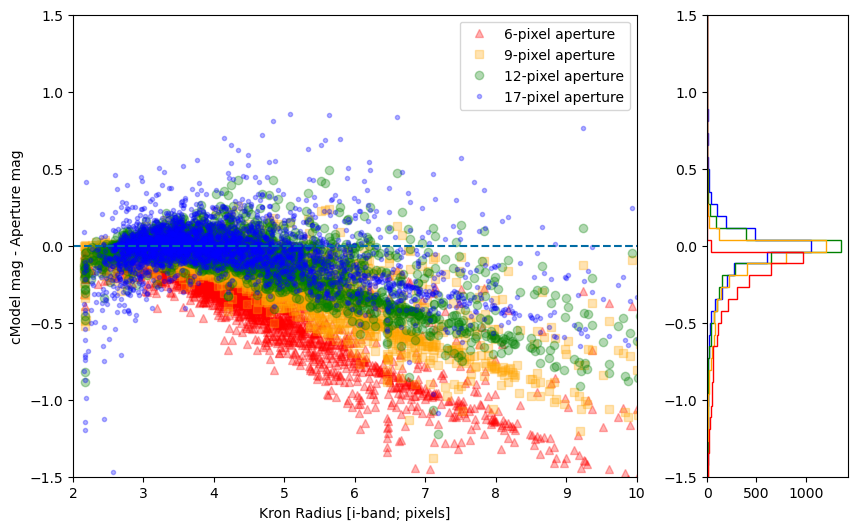

In [21]:
fig, (ax, ax2) = plt.subplots(ncols=2, nrows=1,
                              width_ratios=[0.8, 0.2], figsize=(10, 6))

ylims = [-1.5, 1.5]
ax.plot(i_kronRad, (cmodel_mag-ap06_mag), '^', alpha=.3,
        label='6-pixel aperture', color='red')
ax.plot(i_kronRad, (cmodel_mag-ap09_mag), 's', alpha=.3,
        label='9-pixel aperture', color='orange')
ax.plot(i_kronRad, (cmodel_mag-ap12_mag), 'o', alpha=.3,
        label='12-pixel aperture', color='green')
ax.plot(i_kronRad, (cmodel_mag-ap17_mag), '.', alpha=.3,
        label='17-pixel aperture', color='blue')

ax2.hist((cmodel_mag-ap17_mag), edgecolor='blue', orientation="horizontal",
         bins=np.linspace(ylims[0], ylims[1], 40), align='mid',
         histtype="step", stacked=True, fill=False)
ax2.hist((cmodel_mag-ap12_mag), edgecolor='green', orientation="horizontal",
         bins=np.linspace(ylims[0], ylims[1], 40), align='mid',
         histtype="step", stacked=True, fill=False)
ax2.hist((cmodel_mag-ap09_mag), edgecolor='orange', orientation="horizontal",
         bins=np.linspace(ylims[0], ylims[1], 40), align='mid',
         histtype="step", stacked=True, fill=False)
ax2.hist((cmodel_mag-ap06_mag), edgecolor='red', orientation="horizontal",
         bins=np.linspace(ylims[0], ylims[1], 40), align='mid',
         histtype="step", stacked=True, fill=False)

ax2.set_ylim(ylims)
ax.axhline(0, linestyle='--')
ax.set_xlabel('Kron Radius [i-band; pixels]')
ax.set_ylabel('cModel mag - Aperture mag')
ax.set_ylim(ylims)
ax.set_xlim([2, 10])
ax.legend()


> Figure 1: A comparison of the difference between cModel photometry and aperture photometry measured by the LSST pipelines for four different aperture sizes as a function of galaxy size (as measured using the Kron radius). The left panel shows the scatter plot of difference in photometry vs Kron radius, and the right panel shows a histogram of these values that demonstrate that larger aperture sizes have photometry that is closer to the cModel. The right panel shows histograms of the data in the left panel, where the colors indicate for the same data in each panel.

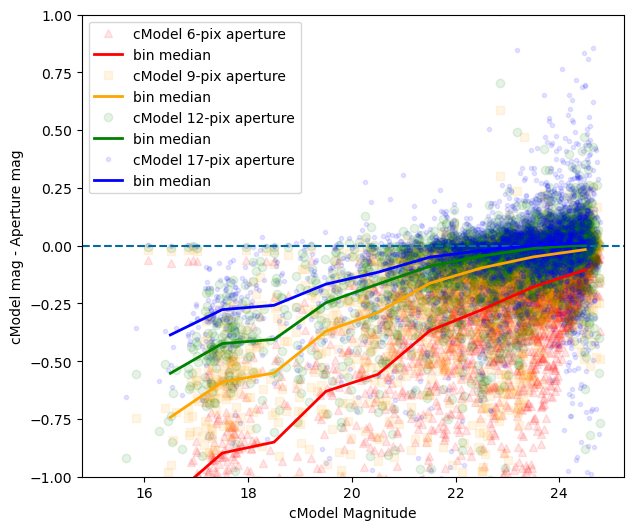

In [13]:
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(7, 6))
ylims = [-1.2, 1.2]
bins = np.arange(16, 27, 1)

ax.plot(cmodel_mag, (cmodel_mag-ap06_mag), '^', alpha=.1,
        label='cModel 6-pix aperture', color='red')
x = cmodel_mag
y = (cmodel_mag-ap06_mag)
bin_mean, bin_edge, binnum = binned_statistic(x, y,
                                              statistic='median', bins=bins)
binctr = bin_edge[:-1] + (bin_edge[1:]-bin_edge[:-1])/2
ax.plot(binctr, bin_mean, color='red', lw=2, label='bin median', zorder=10)

ax.plot(cmodel_mag, (cmodel_mag-ap09_mag), 's', alpha=.1,
        label='cModel 9-pix aperture', color='orange')
x = cmodel_mag
y = (cmodel_mag-ap09_mag)
bin_mean, bin_edge, binnum = binned_statistic(x, y,
                                              statistic='median', bins=bins)
binctr = bin_edge[:-1] + (bin_edge[1:]-bin_edge[:-1])/2
ax.plot(binctr, bin_mean, color='orange', lw=2,
        label='bin median', zorder=10)

ax.plot(cmodel_mag, (cmodel_mag-ap12_mag), 'o', alpha=.1,
        label='cModel 12-pix aperture', color='green')
x = cmodel_mag
y = (cmodel_mag-ap12_mag)
bin_mean, bin_edge, binnum = binned_statistic(x, y,
                                              statistic='median', bins=bins)
binctr = bin_edge[:-1] + (bin_edge[1:]-bin_edge[:-1])/2
ax.plot(binctr, bin_mean, color='green', lw=2,
        label='bin median', zorder=10)

ax.plot(cmodel_mag, (cmodel_mag-ap17_mag), '.', alpha=.1,
        label='cModel 17-pix aperture', color='blue')
x = cmodel_mag
y = (cmodel_mag-ap17_mag)
bin_mean, bin_edge, binnum = binned_statistic(x, y,
                                              statistic='median', bins=bins)
binctr = bin_edge[:-1] + (bin_edge[1:]-bin_edge[:-1])/2
ax.plot(binctr, bin_mean, color='blue', lw=2,
        label='bin median', zorder=10)

ax.axhline(0, linestyle='--')
ax.set_xlabel('cModel Magnitude')
ax.set_ylabel('cModel mag - Aperture mag')
ax.set_ylim([-1, 1])
ax.legend()


> Figure 2: A similar comparison of the difference between cModel photometry and aperture photometry measured by the LSST pipelines for four different aperture sizes, this time as a function of cModel magnitude. Running median is included.

These two figures show that the aperture photometry typically under-estimates the flux relative to the total flux estimated using cModel. As expected, there is a general trend for larger apertures to get closer to the total flux from cModel for large galaxies (i.e. whose Kron Radius is larger). There is also a general trend for the aperture photometry to be less discrepant at fainter magnitudes, since faint galaxies tend to be small.


### 2.3.3 Compare Kron and GaaP photometry to cModel

In the next cell, compare the cModel instead to the Kron and GaaP measures.

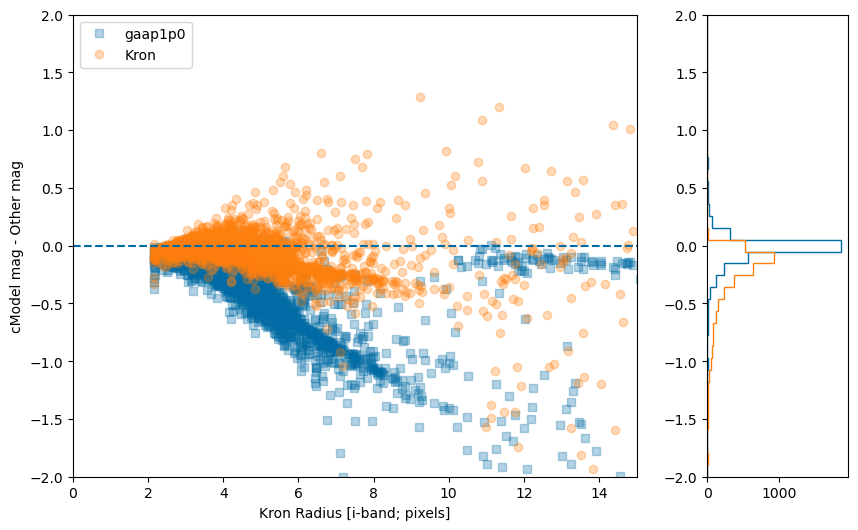

In [14]:
fig, (ax, ax2) = plt.subplots(ncols=2, nrows=1,
                              width_ratios=[0.8, 0.2], figsize=(10, 6))
ylims = [-2, 2]

ax.plot(i_kronRad, (cmodel_mag-gaap_mag), 's', alpha=.3,
        label='gaap1p0')

ax.plot(i_kronRad, (cmodel_mag-kron_mag), 'o', alpha=.3,
        label='Kron')

ax2.hist((cmodel_mag-kron_mag), orientation="horizontal",
         bins=np.linspace(ylims[0], ylims[1], 40), align='mid',
         histtype="step", stacked=True, fill=False)
ax2.hist((cmodel_mag-gaap_mag), orientation="horizontal",
         bins=np.linspace(ylims[0], ylims[1], 40), align='mid',
         histtype="step", stacked=True, fill=False)

ax2.set_ylim(ylims)
ax.axhline(0, linestyle='--')
ax.set_xlabel('Kron Radius [i-band; pixels]')
ax.set_ylabel('cModel mag - Other mag')
ax.set_ylim(ylims)
ax.set_xlim([0, 15])
ax.legend()


> Figure 3: The left panel figure shows the i-band magnitude difference between cModel and Kron (blue squares) and between cModel and gaap1p0 (orange circles) vs the Kron radius (a proxy for galaxy size) for the galaxies in the query.  The dashed line indicates where the two magnitudes would have the same value. The gaap1p0 magnitude always underestimates the flux, while the Kron magnitude approaches the cModel magnitude for fainter galaxies. The right panel shows the histogram of the magnitude differences in the left panel, illustrating that while cModel - Kron magnitudes are similar on average (blue histogram) the gaap1p0 systematically underestimates the flux relative to cModel (orange histogram). 

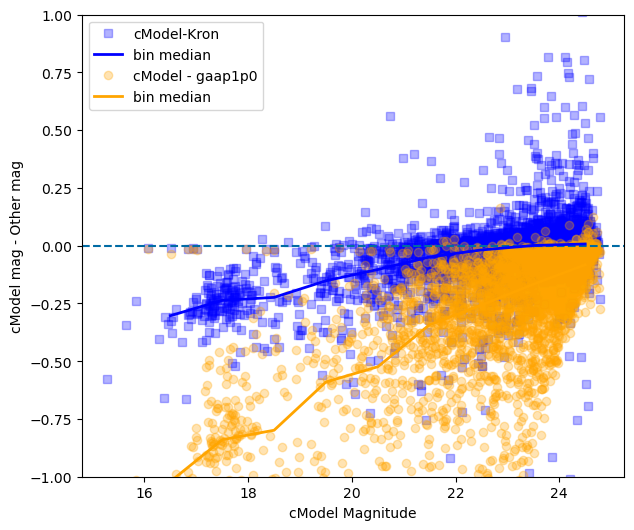

In [15]:
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(7, 6))
ylims = [-1.2, 1.2]

ax.plot(cmodel_mag, (cmodel_mag-kron_mag), 's', alpha=.3,
        label='cModel-Kron', color='blue')
x = cmodel_mag
y = (cmodel_mag-kron_mag)
bin_mean, bin_edge, binnum = binned_statistic(x, y,
                                              statistic='median', bins=bins)
binctr = bin_edge[:-1] + (bin_edge[1:]-bin_edge[:-1])/2
ax.plot(binctr, bin_mean, color='blue', lw=2, label='bin median', zorder=10)

ax.plot(cmodel_mag, (cmodel_mag-gaap_mag), 'o', alpha=.3,
        label='cModel - gaap1p0', color='orange')

x = cmodel_mag
y = (cmodel_mag-gaap_mag)
bin_mean, bin_edge, binnum = binned_statistic(x, y,
                                              statistic='median', bins=bins)
binctr = bin_edge[:-1] + (bin_edge[1:]-bin_edge[:-1])/2
ax.plot(binctr, bin_mean, color='orange', lw=2, label='bin median', zorder=10)

ax.axhline(0, linestyle='--')
ax.set_xlabel('cModel Magnitude')
ax.set_ylabel('cModel mag - Other mag')
ax.set_ylim([-1, 1])
ax.legend()

> Figure 4: The figure shows the i-band magnitude difference between cModel and Kron (blue squares) and between cModel and gaap1p0 (orange circles) vs the cModel magnitude for the galaxies in the query. The lines correspond to the running median in magnitude bins to illustrate the trend. The dashed line indicates where the two magnitudes would have the same value. The gaap1p0 magnitude always underestimates the flux, while the Kron magnitude approaches the cModel magnitude for fainter galaxies.

The above plots show the parameter space where Kron fluxes do not correspond well with total fluxes (as measured by cModel). This indcates that Kron fluxes will underestimate the total fluxes in the regime of bright magnitudes and large Kron radius. Generally, cModel is recommended over Kron.

As explained in Section 1, GaaP fluxes are not meant to measure total fluxes (from these plots it is clear there is a strong discrepancy with cModel) but GaaP measurements are the best and most robust for measuring robust integrated colors between different filters. Thus GaaP measurements should be used for Spectral Energy Distribution (SED) or photometric redshift modeling, or for color selections.

# 3. Visualize photometric measurements

Here make a cutout of a large galaxy in the cluster and compare the photometric aperture sizes of the different photometric measurements. The cell below also demonstrates how to reconstruct the Kron aperture using the corresponding shape parameters in the `objectTable`. The position angle `theta` is defined in radians counterclockwise from the x-axis. This cell will plot for an elongated edge-on galaxy (`objectId` of 1909948454470183768) to ensure that the visualization emphasizes the difference between the elliptical Kron aperture to the circular aperture. 

Alternatively, it is possible to pick a different bright object that has large size using the command

`wh = np.where((tab['i_kronRad'] > 8) & (cmodel_mag < 20))[0]`

Note that the pixel scale of the LSST data is 0.2 arcseconds per pixel.

Kron magnitude =  20.181955982562123
17-pix Aperture mag =  20.371157089300738
35-pix Aperture mag =  20.148237741312414
cModel mag =  19.780989378300163


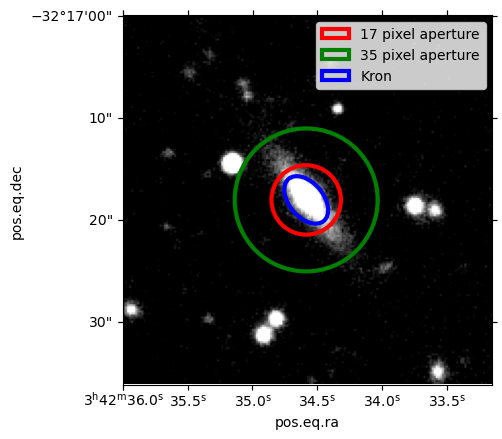

In [16]:
wh = np.where((tab['objectId'] == 1909948454470183768))[0]
indx = 0

arcsec_per_pix = 0.2

mem = make_image_cutout(service, tab['coord_ra'][wh][indx],
                        tab['coord_dec'][wh][indx], cutout_size=0.005)

cutout = ExposureF(mem)

axes = ellipses.Axes(ellipses.Quadrupole(tab['shape_xx'][wh][indx],
                                         tab['shape_yy'][wh][indx],
                                         tab['shape_xy'][wh][indx]))
Rmaj = axes.getA()
Rmin = axes.getB()
theta = axes.getTheta()

plt.subplot(projection=WCS(cutout.getWcs().getFitsMetadata()))
extent = (cutout.getBBox().beginX, cutout.getBBox().endX,
          cutout.getBBox().beginY, cutout.getBBox().endY)

plt.imshow(cutout.image.array, vmin=.1, vmax=0.8,
           extent=extent, origin='lower', cmap='gray')

coord = SkyCoord(ra=tab['coord_ra'][wh][indx]*u.degree,
                 dec=tab['coord_dec'][wh][indx]*u.degree, frame='icrs')

aperture = SkyCircularAperture(coord, r=17 * arcsec_per_pix * u.arcsec)
pix_aperture = aperture.to_pixel(WCS(cutout.getWcs().getFitsMetadata()))
pix_aperture.plot(color='r', lw=3, label='17 pixel aperture')

aperture = SkyCircularAperture(coord, r=35 * arcsec_per_pix * u.arcsec)
pix_aperture = aperture.to_pixel(WCS(cutout.getWcs().getFitsMetadata()))
pix_aperture.plot(color='g', lw=3, label='35 pixel aperture')

aperture = SkyEllipticalAperture(coord,
                                 2.5 * Rmaj * arcsec_per_pix * u.arcsec,
                                 2.5 * Rmin * arcsec_per_pix * u.arcsec,
                                 theta=(np.pi/2 + theta) * u.rad)

pix_aperture = aperture.to_pixel(WCS(cutout.getWcs().getFitsMetadata()))
pix_aperture.plot(color='b', lw=3, label='Kron')
plt.legend()

print("Kron magnitude = ", kron_mag[wh][indx])
print("17-pix Aperture mag = ", ap17_mag[wh][indx])
print("35-pix Aperture mag = ", ap35_mag[wh][indx])
print("cModel mag = ", cmodel_mag[wh][indx])


> Figure 5: An i-band image cutout of an example galaxy (grayscale). The photometric apertures are overplotted including Kron (blue), the 17 pixel aperture (red) and the 35 pixel aperture (green). None of the apertures enclose all of the flux visible from the galaxy, which is why the photometry measures less flux than the total flux from cModel.

The above figure shows more clearly that there is some fraction of the galaxy's light excluded by each of these photometric apertures. Further, printing the different photometry measurements illustrates how these assumed apertures will change the measured flux (compared to the total flux measured by cModel, which approximates the total magnitude using sersic models for the light profile).  

# 4. Application of GaaP Photometry: galaxy colors

This section demonstrates using GaaP photometry to calculate accurate galaxy colors to identify different types of galaxies. First, define magnitudes from u, g, r, and i band photometry. The second cell will then compare the colors of galaxies that overlap the galaxy cluster with that in the field. In clusters, galaxies tend to be old, red elliptical galaxies and thus exhibit a well defined red sequence in color space. 

For comparison, search for and plot galaxies from a random location that will be dominated by bluer star forming galaxies


In [17]:
random_RA = 56.7506834813934
random_dec = -31.28892993702273

query = "SELECT obj.objectId, obj.coord_ra, obj.coord_dec, " + \
        "obj.detect_fromBlend, obj.detect_isIsolated, " + \
        "obj.i_blendedness, obj.i_extendedness, " + \
        "obj.i_kronFlux, obj.i_kronFluxErr, obj.i_kronRad, " + \
        "obj.i_cModelFlux, obj.i_cModelFluxErr, obj.i_gaap1p0Flux, " + \
        "obj.g_gaap1p0Flux, " + \
        "obj.i_kronFlux_flag, obj.i_cModel_flag " + \
        "FROM dp02_dc2_catalogs.Object AS obj " + \
        "WHERE (obj.detect_isPrimary = 1) AND " + \
        "(obj.i_cModelFlux/obj.i_cModelFluxErr > 20) AND " + \
        "(obj.i_extendedness = 1) AND " + \
        "(obj.i_kronFlux_flag = 0) AND (obj.i_cModel_flag = 0) AND " + \
        "CONTAINS(POINT('ICRS', obj.coord_ra, obj.coord_dec), " + \
        "CIRCLE('ICRS',"+str(random_RA)+","+str(random_dec)+", 0.1)) = 1 "

job = service.submit_job(query)
job.run()
job.wait(phases=['COMPLETED', 'ERROR'])
print('Job phase is', job.phase)

results = job.fetch_result()
tab2 = results.to_table()


Job phase is COMPLETED


First, calculate the magnitudes of galaxies in the 'random' location (outside the galaxy cluster) and also the magnitudes for the other filters near the galaxy cluster from the query performed in Section 2. This will enable plotting their colors.

> **Warning:** Like in Section 2.3, the following cell will produce warnings for invalid value encountered in log10, which happens if the source flux is negative. This happens for a small number of objects and since the goal of the plot is to see the distribution of the majority of sources, the warning can be safely ignored. 

In [18]:
i_random_gaap_mag = -2.50 * np.log10(tab2['i_gaap1p0Flux']) + 31.4
g_random_gaap_mag = -2.50 * np.log10(tab2['g_gaap1p0Flux']) + 31.4

g_cluster_gaap_mag = -2.50 * np.log10(tab['g_gaap1p0Flux']) + 31.4
i_cluster_gaap_mag = -2.50 * np.log10(tab['i_gaap1p0Flux']) + 31.4


/tmp/ipykernel_8898/1509710904.py:2: RuntimeWarning: invalid value encountered in log10
  g_random_gaap_mag = -2.50 * np.log10(tab2['g_gaap1p0Flux']) + 31.4
/tmp/ipykernel_8898/1509710904.py:4: RuntimeWarning: invalid value encountered in log10
  g_cluster_gaap_mag = -2.50 * np.log10(tab['g_gaap1p0Flux']) + 31.4


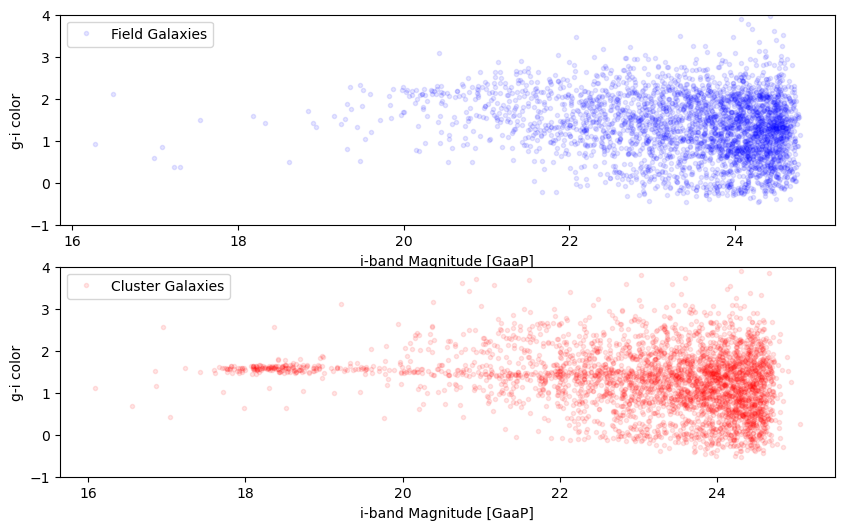

In [19]:
fig, (ax, ax1) = plt.subplots(ncols=1, nrows=2, figsize=(10, 6))

ax.plot(i_random_gaap_mag, (g_random_gaap_mag-i_random_gaap_mag),
        '.', alpha=.1, color='blue', label='Field Galaxies')
ax.set_xlabel('i-band Magnitude [GaaP]')
ax.set_ylabel('g-i color')
ax.set_ylim([-1, 4])
ax.legend()

ax1.plot(i_cluster_gaap_mag, (g_cluster_gaap_mag-i_cluster_gaap_mag),
         '.', alpha=.1, color='red', label='Cluster Galaxies')
ax1.set_xlabel('i-band Magnitude [GaaP]')
ax1.set_ylabel('g-i color')
ax1.set_ylim([-1, 4])
ax1.legend()

> Figure 6: 

A very nice red sequence appears from the red, old galaxies in the cluster! 

# 5. Application of aperture photometry: radial profile

A science application for the aperture photometry is easy visualization of the radial profile of galaxies. In the cell below, make this plot for both a large galaxy (first) and a smaller galaxy of similar brightness (second). The query looks for bright galaxies whose cModel magnitude ~ 20. Dividing the aperture flux by the surface area of the aperture yields the surface brightness, which can be plotted as a function of radius from the center of the galaxy to compare radial light profiles.

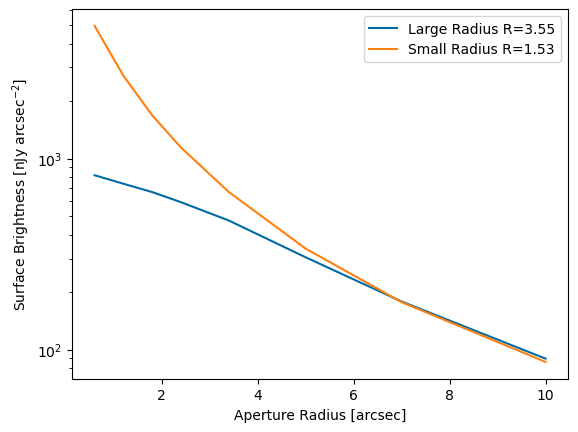

In [20]:
wh = np.where((tab['i_kronRad'] > 8) & (cmodel_mag > 19.9)
              & (cmodel_mag < 20.1))[0]
indx = 2

rad = np.array([3, 6, 9, 12, 17, 25, 35, 50]) * arcsec_per_pix
area = np.pi * rad**2
profile = np.array([tab['i_ap03Flux'][wh][indx], tab['i_ap06Flux'][wh][indx],
                    tab['i_ap09Flux'][wh][indx], tab['i_ap12Flux'][wh][indx],
                    tab['i_ap17Flux'][wh][indx], tab['i_ap25Flux'][wh][indx],
                    tab['i_ap35Flux'][wh][indx],
                    tab['i_ap50Flux'][wh][indx]]) / area

plt.plot(rad, profile,
         label='Large Radius R='
         + str(round(i_kronRad[wh][indx]*arcsec_per_pix, 2)))
plt.xlabel('Aperture Radius [arcsec]')
plt.ylabel(r'Surface Brightness [nJy arcsec$^{-2}$]')

wh2 = np.where((tab['i_kronRad'] < 8) & (tab['i_kronRad'] > 5)
               & (cmodel_mag > 19.9) & (cmodel_mag < 20.1))[0]

indx = 1

profile = np.array([tab['i_ap03Flux'][wh2][indx], tab['i_ap06Flux'][wh2][indx],
                    tab['i_ap09Flux'][wh2][indx], tab['i_ap12Flux'][wh2][indx],
                    tab['i_ap17Flux'][wh2][indx], tab['i_ap25Flux'][wh2][indx],
                    tab['i_ap35Flux'][wh2][indx],
                    tab['i_ap50Flux'][wh2][indx]])/area

plt.plot(rad, profile,
         label='Small Radius R='
         + str(round(i_kronRad[wh2][indx]*arcsec_per_pix, 2)))
plt.legend()
plt.yscale('log')

> Figure 7: 

# 6. Exercise for the learner

Compare the `<f>_free_cModelFlux` measurements to `<f>_cModelFlux` in the filters that are not the reference band where the `<f>_cModelFlux` was measured (i.e. `refBand`). Investigate how leaving the cModel measurements free differs from the one measured with parameters fixed to the `refBand`, as a function of decreasing signal to noise. 